In [6]:
# load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pdb

# for statistical analysis
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.2f}'.format
from IPython.core.display import display, HTML
# uncomment this line and run the cell --> fit the cells to screen. Comment and re-run to disable full width.
# display(HTML("<style>.container { width:100% !important; }</style>"))
plt.style.use('seaborn-darkgrid')

### Input

In [2]:
## probably not usable class_id: 26, 56
## input
data_path = "../data"
input_path = f"{data_path}/experiment-result-2021-06-15.csv"
input_path_uncomp = f"{data_path}/experiment-uncomp-06-14-2021.csv"
gt_tracking_path = f"{data_path}/experiment_gt_tracking-2021-06-05.csv"
visual_metric = "mAP-50"
averaged_result_class = "all"

## Data Wrangling

In [3]:
df = pd.read_csv(input_path, sep=',')
df_uncomp = pd.read_csv(input_path_uncomp, sep=',')
df = pd.concat([df_uncomp, df])
df['F1'] = 2 * df['Prcn'] * df['Rcll'] / (df['Prcn'] + df['Rcll'])
df['MOTP'] = ( 1 - df['MOTP'] ) * 100
# filter df
header = ['class_cat', 'seq_name', 'class_id', 'qp', 'msr', 'idtp', 'idfp', 'idfn', 'IDF1', 'IDP', 'IDR',
          'Rcll', 'Prcn', 'F1', 'GT', 'MT', 'PT', 'ML', 'num_detections', 'FP', 'FN', 'IDs', 'FM', 'mAP', 'MOTA', 'MOTP']
df = df[header] # re-arrange
df.columns = ['class_cat', 'seq_name', 'class_id', 'QP', 'MSR', 'IDTP', 'IDFP', 'IDFN', 'IDF1', 'IDP', 'IDR',
          'Recall', 'Precision', 'F1', 'GT', 'MT', 'PT', 'ML', 'TP', 'FP', 'FN', 'IDs', 'FM', 'mAP-50', 'MOTA', 'MOTP']

df_all = df[df['class_id'] == f"{averaged_result_class}"]
# display(df_all)
seq_list = list(df['seq_name'].unique())
num_seq = len(seq_list)
temp_data = df_all[df_all['seq_name'] == "BasketballDrive"]


#initialize df_summary
#header_std = [f"{col}_std" for col in header ]#if col !='qp' and col != 'msr']
header = ['QP', 'MSR', 'IDTP', 'IDFP', 'IDFN', 'IDF1', 'IDP', 'IDR',
          'Recall', 'Precision', 'F1', 'GT', 'MT', 'PT', 'ML', 'TP', 'FP', 'FN', 'IDs', 'FM', 'mAP-50', 'MOTA', 'MOTP']

df_summary = pd.DataFrame(0, index=np.arange(len(temp_data)), columns=header)

# averaging
for seq_name in seq_list:
    # exclude training sequence and exclude Cactus as well if tracking person only 
    if seq_name == "PartyScene": 
        continue
    df_seq_all = df_all[df_all['seq_name'] == seq_name]
    df_seq_all.pop('class_cat')
    df_seq_all.pop('seq_name')
    df_seq_all.pop('class_id')

#     df_seq_all = df_seq_all.replace(np.nan, 0)
#     print(seq_name)
#     display(df_seq_all)

    for col in df_seq_all:
        if col == 'QP' or col == 'MSR':
            df_summary[col] = df_seq_all[col].values
        else:
            df_summary[col] += df_seq_all[col].values


for col in df_summary:
    if col !='QP' and col != 'MSR':
        df_summary[col] = df_summary[col] / num_seq

In [4]:
df_gt = pd.read_csv(gt_tracking_path, sep=',')
df_gt['F1'] = 2 * df_gt['Prcn'] * df_gt['Rcll'] / (df_gt['Prcn'] + df_gt['Rcll'])
df_gt['MOTP'] = ( 1 - df_gt['MOTP'] ) * 100
# filter df
header = ['class_cat', 'seq_name', 'class_id', 'qp', 'msr', 'idtp', 'idfp', 'idfn', 'IDF1', 'IDP', 'IDR',
          'Rcll', 'Prcn', 'F1', 'GT', 'MT', 'PT', 'ML', 'num_detections', 'FP', 'FN', 'IDs', 'FM', 'mAP', 'MOTA', 'MOTP']
df_gt = df_gt[header] # re-arrange
df_gt.columns = ['class_cat', 'seq_name', 'class_id', 'QP', 'MSR', 'IDTP', 'IDFP', 'IDFN', 'IDF1', 'IDP', 'IDR',
          'Recall', 'Precision', 'F1', 'GT', 'MT', 'PT', 'ML', 'TP', 'FP', 'FN', 'IDs', 'FM', 'mAP-50', 'MOTA', 'MOTP']

df_all_gt = df_gt[df_gt['class_id'] == f"{averaged_result_class}"]

seq_list = list(df['seq_name'].unique())
num_seq = len(seq_list)
temp_data = df_all_gt[df_all_gt['seq_name'] == "BasketballDrive"]


#initialize df_summary_gt
#header_std = [f"{col}_std" for col in header ]#if col !='qp' and col != 'msr']
header = ['QP', 'MSR', 'IDTP', 'IDFP', 'IDFN', 'IDF1', 'IDP', 'IDR',
          'Recall', 'Precision', 'F1', 'GT', 'MT', 'PT', 'ML', 'TP', 'FP', 'FN', 'IDs', 'FM', 'mAP-50', 'MOTA', 'MOTP']

df_summary_gt = pd.DataFrame(0, index=np.arange(len(temp_data)), columns=header)

# averaging
for seq_name in seq_list:
    # exclude training sequence and exclude Cactus as well if tracking person only 
    if seq_name == "PartyScene": 
        continue
    df_seq_all = df_all_gt[df_all_gt['seq_name'] == seq_name]
    df_seq_all.pop('class_cat')
    df_seq_all.pop('seq_name')
    df_seq_all.pop('class_id')

#     df_seq_all = df_seq_all.replace(np.nan, 0)
#     print(seq_name)
#     display(df_seq_all)

    for col in df_seq_all:
        if col == 'QP' or col == 'MSR':
            df_summary_gt[col] = df_seq_all[col].values
        else:
            df_summary_gt[col] += df_seq_all[col].values


for col in df_summary_gt:
    if col !='QP' and col != 'MSR':
        df_summary_gt[col] = df_summary_gt[col] / num_seq

## Visualization

C:\Users\Takehiro\Miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Takehiro\Miniconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Takehiro\Miniconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


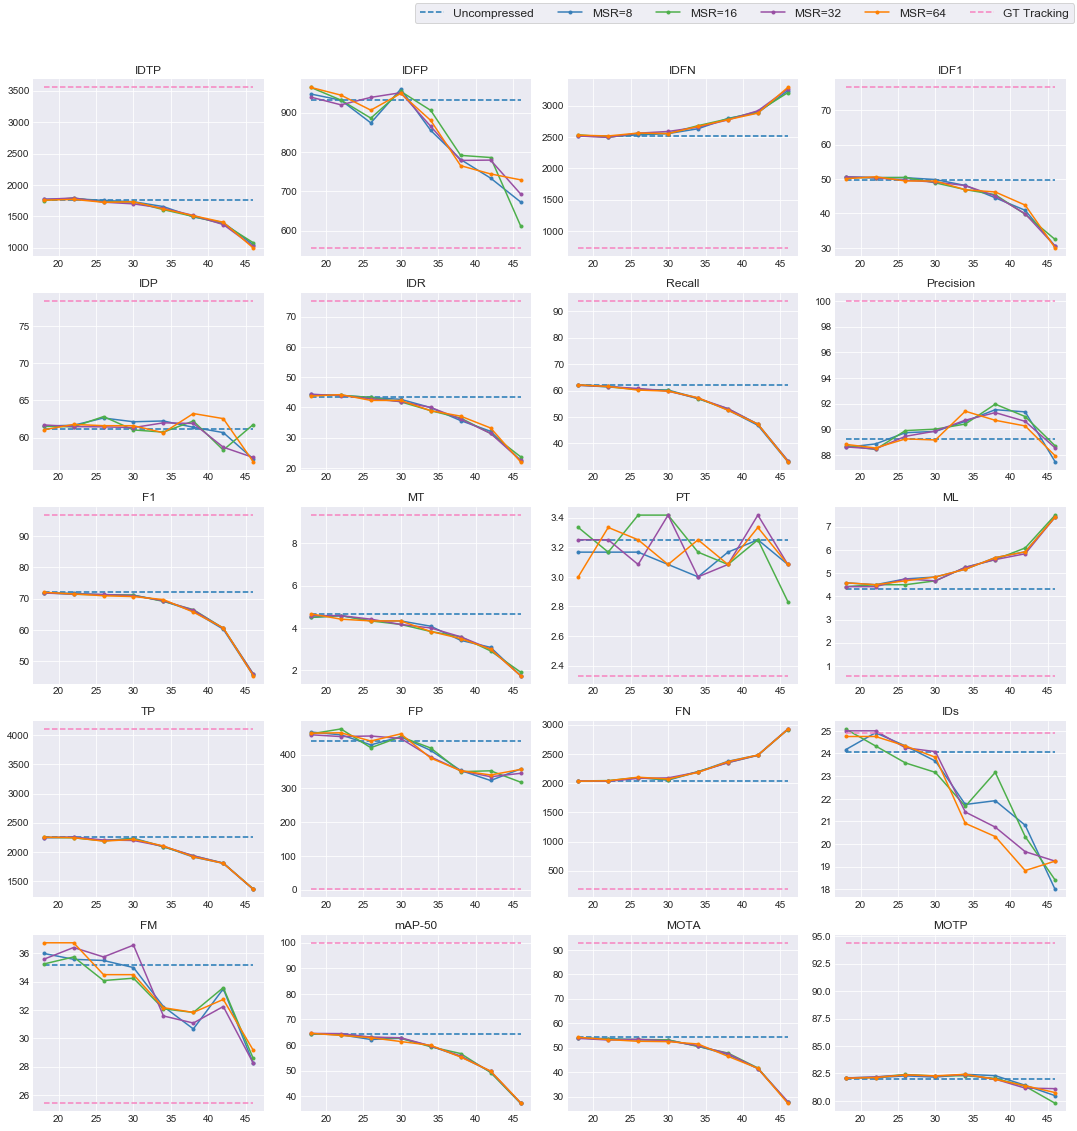

In [5]:
plt.style.use('seaborn-darkgrid')

df_seq = df_summary.query('QP > 0 and MSR > 0')
df_seq_cl_uncomp = df_summary.query('QP == 0 and MSR == 0')

fig, axs = plt.subplots(5, 4, figsize=(15,15))
palette = plt.get_cmap('Set1')

num = 0
for row in range(5):
    for col in range(4):
        if num == 9: # skiping GT, since it is constant, no need to plot it
            num += 1
        # plot uncompressed result
        x = df_seq.query('MSR == 8')['QP']
        metric = df_seq.iloc[:, 2+num].name
        y_const = [df_seq_cl_uncomp[metric] for i in range(len(x))]
        axs[row, col].set_title(metric)
        axs[row, col].plot(x, y_const, '--', label='Uncompressed')
        
        # plot metric
        y = df_seq.query('MSR == 8').iloc[:, 2+num]
        axs[row, col].plot(x, y, '.-', label='MSR=8', color=palette(1))
        
        # plot metric
        y = df_seq.query('MSR == 16').iloc[:, 2+num]
        axs[row, col].plot(x, y, '.-', label='MSR=16', color=palette(2))
        
        # plot metric
        y = df_seq.query('MSR == 32').iloc[:, 2+num]
        axs[row, col].plot(x, y, '.-', label='MSR=32', color=palette(3))
        
        # plot metric
        y = df_seq.query('MSR == 64').iloc[:, 2+num]
        axs[row, col].plot(x, y, '.-', label='MSR=64', color=palette(4))
        
        # plot gt tracking result
        y = df_summary_gt.query('MSR == 8').iloc[:, 2+num] # choose 
        axs[row, col].plot(x, y, '--', label='GT Tracking', color=palette(7))
        
    
        num += 1
        
        if row == 0 and col == 0:
            lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
            lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
            fig.legend(lines, labels, loc=4, ncol=6, mode="", borderaxespad=.5,
                       frameon=True, bbox_to_anchor=(0., 1.02, 1., .102), fontsize='large')
            # bbox_to_anchor=(0.125, 0.82, 1., .102)

# lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
# axs[0].legend(lines, labels, loc=4, ncol=4,     mode="", borderaxespad=.5, frameon=True,
#         bbox_to_anchor=(0., 1.02, 1., .102))
        
fig.tight_layout()
# plt.savefig("C:/OneDrive/SFU/ENSC498, 499/images/averaged_all_multiplots_qp_gt.pdf", bbox_inches="tight")

C:\Users\Takehiro\Miniconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
C:\Users\Takehiro\Miniconda3\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\Takehiro\Miniconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


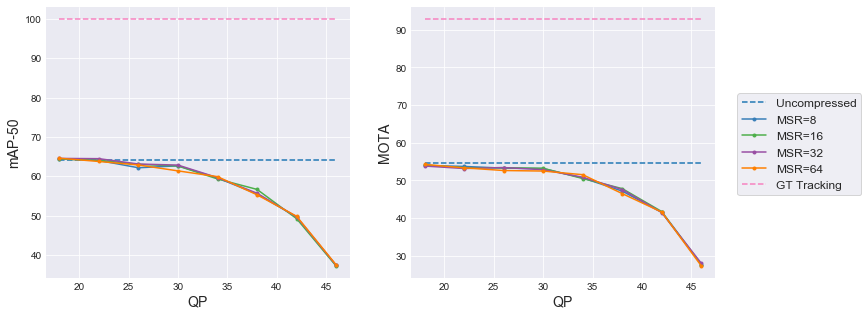

In [6]:
plt.style.use('seaborn-darkgrid')
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
palette = plt.get_cmap('Set1')

# first plot
x = df_summary.query('MSR == 8')['QP']
y_const = [df_summary.query('QP == 0 and MSR == 0')['mAP-50'] for i in range(len(x))]
axs[0].plot(x, y_const, '--', label='Uncompressed')
axs[0].set_ylabel('mAP-50', fontsize=14)
axs[0].set_xlabel('QP', fontsize=14)

# plot metric
y = df_seq.query('MSR == 8')['mAP-50']
axs[0].plot(x, y, '.-', label='MSR=8', color=palette(1))

# plot metric
y = df_seq.query('MSR == 16')['mAP-50']
axs[0].plot(x, y, '.-', label='MSR=16', color=palette(2))

# plot metric
y = df_seq.query('MSR == 32')['mAP-50']
axs[0].plot(x, y, '.-', label='MSR=32', color=palette(3))

# plot metric
y = df_seq.query('MSR == 64')['mAP-50']
axs[0].plot(x, y, '.-', label='MSR=64', color=palette(4))

# plot gt tracking result
y = df_summary_gt.query('MSR == 8')['mAP-50'] 
axs[0].plot(x, y, '--', label='GT Tracking', color=palette(7))


# second plot
x = df_summary.query('MSR == 8')['QP']
y_const = [df_summary.query('QP == 0 and MSR == 0')['MOTA'] for i in range(len(x))]
axs[1].plot(x, y_const, '--', label='Uncompressed')
axs[1].set_ylabel('MOTA', fontsize=14)
axs[1].set_xlabel('QP', fontsize=14)

# plot metric
y = df_seq.query('MSR == 8')['MOTA']
axs[1].plot(x, y, '.-', label='MSR=8', color=palette(1))

# plot metric
y = df_seq.query('MSR == 16')['MOTA']
axs[1].plot(x, y, '.-', label='MSR=16', color=palette(2))

# plot metric
y = df_seq.query('MSR == 32')['MOTA']
axs[1].plot(x, y, '.-', label='MSR=32', color=palette(3))

# plot metric
y = df_seq.query('MSR == 64')['MOTA']
axs[1].plot(x, y, '.-', label='MSR=64', color=palette(4))

# plot gt tracking result
y = df_summary_gt.query('MSR == 8')['MOTA'] 
axs[1].plot(x, y, '--', label='GT Tracking', color=palette(7))

axs[1].legend(loc=1, ncol=1, mode="", borderaxespad=.5,
                   frameon=True, bbox_to_anchor=(0.5, 0.6, 1., .102), fontsize=12);

## Analysis

In [7]:
mAP50_uncomp = np.array(df_all.query('QP == 0 and MSR == 0')['mAP-50'])
mAP50_gt = np.array(df_all_gt.query('QP == 0 and MSR == 0')['mAP-50'])

MOTA_uncomp = np.array(df_all.query('QP == 0 and MSR == 0')['MOTA'])
MOTA_gt = np.array(df_all_gt.query('QP == 0 and MSR == 0')['MOTA'])

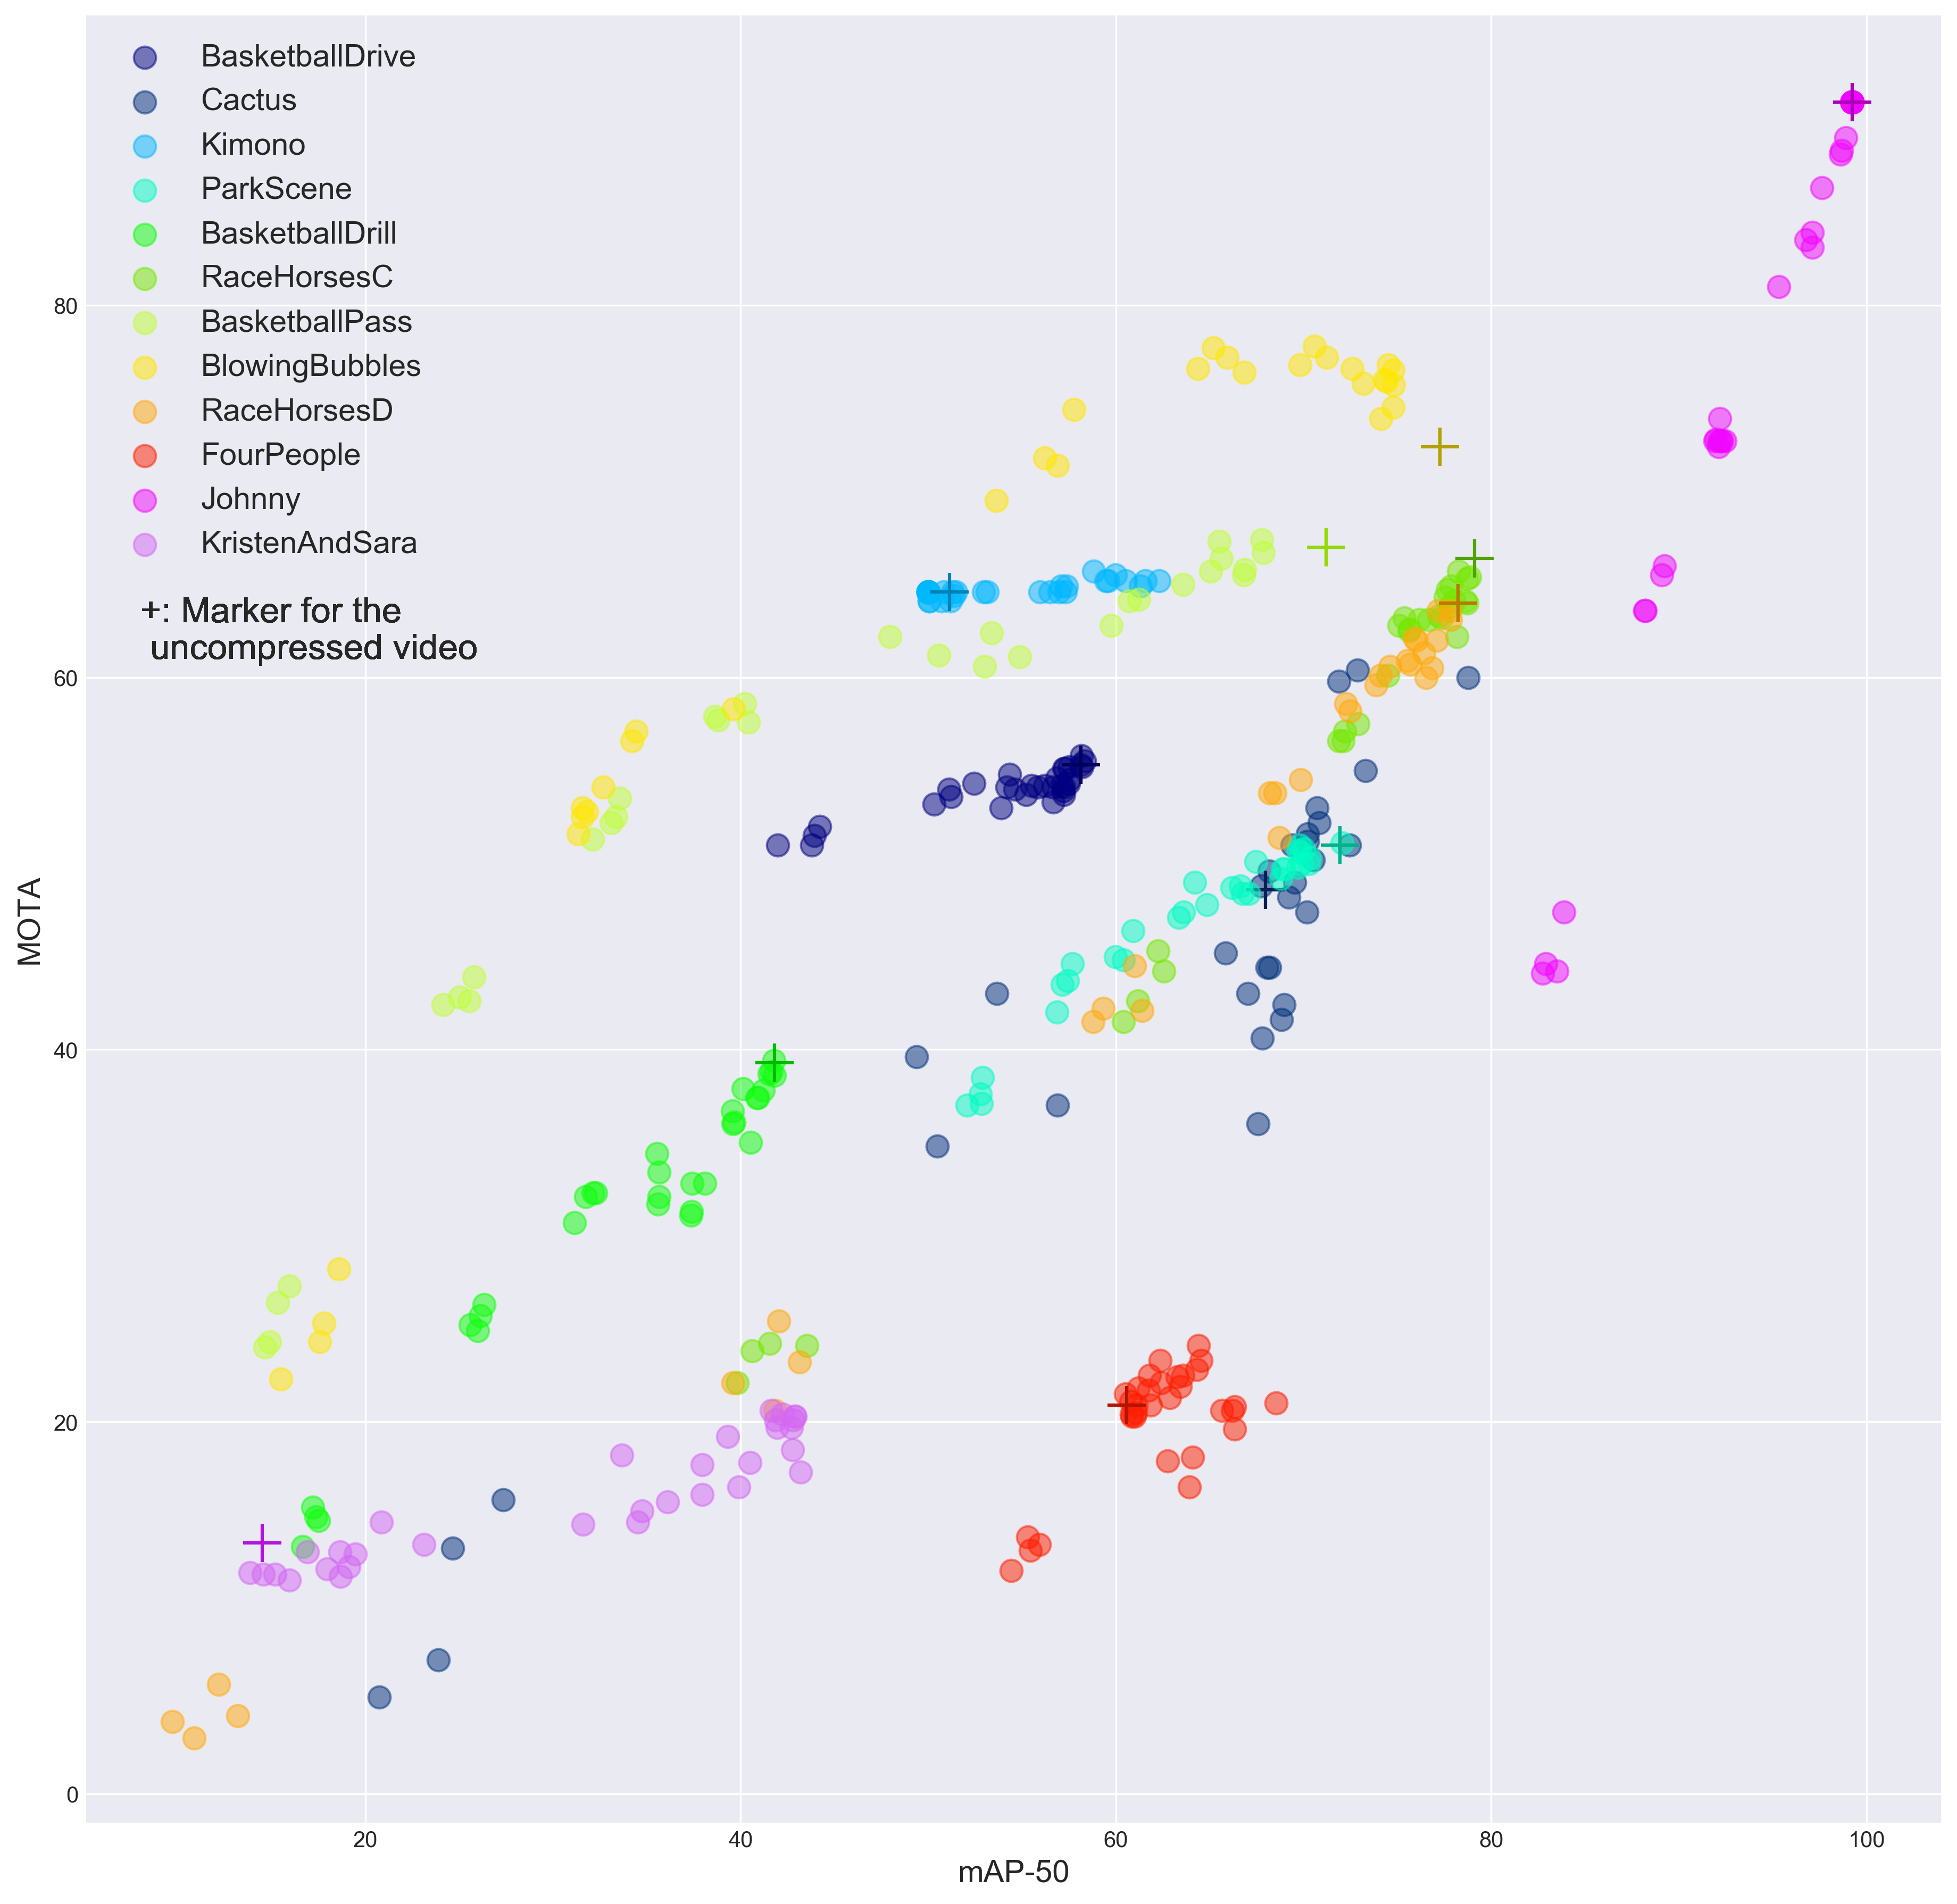

In [44]:
import matplotlib
plt.style.use('seaborn-darkgrid')

# function for darking the '+' marker for better visual
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])

plt.figure(figsize=(15, 15), dpi=300) # need better resolution dpi=300 to display text


seq_name_list = ['BasketballDrive', 'Cactus', 'Kimono', 'ParkScene',
        'BasketballDrill', 'RaceHorsesC',
        'BasketballPass', 'BlowingBubbles', 'RaceHorsesD',
        'FourPeople', 'Johnny', 'KristenAndSara']


palette = plt.get_cmap('gist_ncar')
# palette = plt.get_cmap('nipy_spectral')
num = 0
for seq_name in seq_name_list:
    color = palette(num)

    # compressed color
    x = df_all.query(f'seq_name == "{seq_name}" and QP != 0')['mAP-50']
    y = df_all.query(f'seq_name == "{seq_name}" and QP != 0')['MOTA']
    plt.scatter(x, y, s=100, label=seq_name, color=palette(num), alpha=0.5)
    
    # uncompressed color
    x = df_all.query(f'seq_name == "{seq_name}" and QP == 0')['mAP-50']
    y = df_all.query(f'seq_name == "{seq_name}" and QP == 0')['MOTA']
    plt.scatter(x, y, s=300, marker='+', color=adjust_lightness(palette(num), 0.7))
    num += 0.08
    
    plt.xlabel('mAP-50', fontsize=14)
    plt.ylabel('MOTA', fontsize=14)
    plt.text(8, 61, "+: Marker for the\n uncompressed video", fontsize=16)
    plt.legend(fontsize=14)
# plt.savefig("C:/OneDrive/SFU/ENSC498, 499/images/MOTA_vs_mAP50.pdf", bbox_inches="tight")

(0.7026297034559656, 3.360293619612328e-60)


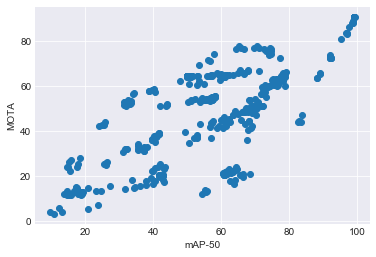

In [17]:
import scipy
x = df_all['mAP-50']
y =  df_all['MOTA']
plt.scatter(x,y)
print(scipy.stats.pearsonr(x,y))
plt.xlabel("mAP-50")
plt.ylabel("MOTA");

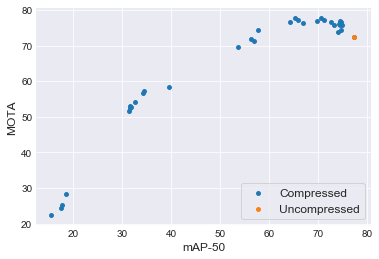

In [15]:
seq_name = "BlowingBubbles"
plt.scatter(df_all.query(f'seq_name=="{seq_name}"')['mAP-50'], df_all.query(f'seq_name=="{seq_name}"')['MOTA'], s=15, label="Compressed")
plt.scatter(df_all.query(f'seq_name=="{seq_name}" and QP == 0')['mAP-50'], df_all.query(f'seq_name=="{seq_name}" and QP == 0')['MOTA'], s=15, label="Uncompressed")
plt.xlabel('mAP-50', fontsize=12)
plt.ylabel('MOTA', fontsize=12)
# plt.title(seq_name)
plt.legend(loc='lower right', ncol=1, mode="", borderaxespad=.5,
                   frameon=True, fontsize=12)
plt.savefig(f"C:/OneDrive/SFU/ENSC498, 499/images/MOTA_vs_mAP50_{seq_name}.pdf", bbox_inches="tight")

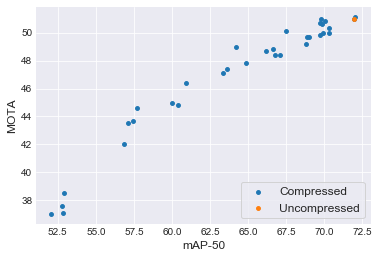

In [50]:
seq_name = "ParkScene"
plt.scatter(df_all.query(f'seq_name=="{seq_name}"')['mAP-50'], df_all.query(f'seq_name=="{seq_name}"')['MOTA'], s=15, label="Compressed")
plt.scatter(df_all.query(f'seq_name=="{seq_name}" and QP == 0')['mAP-50'], df_all.query(f'seq_name=="{seq_name}" and QP == 0')['MOTA'], s=15, label="Uncompressed")
plt.xlabel('mAP-50', fontsize=12)
plt.ylabel('MOTA', fontsize=12)
# plt.title(seq_name)
plt.legend(loc='lower right', ncol=1, mode="", borderaxespad=.5,
                   frameon=True, fontsize=12)
# plt.savefig(f"C:/OneDrive/SFU/ENSC498, 499/images/MOTA_vs_mAP50_{seq_name}.pdf", bbox_inches="tight")

In [11]:
np.mean(mAP50_uncomp) / np.mean(mAP50_gt)

0.6425704416000001

In [12]:
np.std(MOTA_uncomp / MOTA_gt, ddof=1)

0.2439770825572976